NOTE: there are two locations in the code where file paths must be changed to reflect the location of files in google drive: one for fires.csv and one for the US map.

# **INSTALLING/IMPORTING PACKAGES**

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField,StringType, IntegerType, FloatType, BooleanType
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **LOADING DATA USING SQL**

In [ ]:
#import selected columns & create a pandas data frame using SQL
spark = SparkSession.builder \
    .appName("Dataset1") \
    .getOrCreate()

schema = StructType([
    StructField("OBJECTID", IntegerType(), True),
    StructField("FOD_ID", IntegerType(), True),
    StructField("FPA_ID", StringType(), True),
    StructField("SOURCE_SYSTEM_TYPE", StringType(), True),
    StructField("SOURCE_SYSTEM", StringType(), True),
    StructField("NWCG_REPORTING_AGENCY", StringType(), True),
    StructField("NWCG_REPORTING_UNIT_ID", StringType(), True),
    StructField("NWCG_REPORTING_UNIT_NAME", StringType(), True),
    StructField("SOURCE_REPORTING_UNIT", IntegerType(), True),
    StructField("SOURCE_REPORTING_UNIT_NAME", StringType(), True),

    StructField("LOCAL_FIRE_REPORT_ID", IntegerType(), True),
    StructField("LOCAL_INCIDENT_ID", StringType(), True),
    StructField("FIRE_CODE", StringType(), True),
    StructField("FIRE_NAME", StringType(), True),
    StructField("ICS_209_INCIDENT_NUMBER", StringType(), True),
    StructField("ICS_209_NAME", StringType(), True),
    StructField("MTBS_ID", StringType(), True),
    StructField("MTBS_FIRE_NAME", StringType(), True),
    StructField("COMPLEX_NAME", StringType(), True), ######
    StructField("FIRE_YEAR", IntegerType(), True),

    StructField("DISCOVERY_DATE", FloatType(), True),
    StructField("DISCOVERY_DOY", IntegerType(), True),
    StructField("DISCOVERY_TIME", StringType(), True),
    StructField("STAT_CAUSE_CODE", FloatType(), True),
    StructField("STAT_CAUSE_DESCR", StringType(), True),
    StructField("CONT_DATE", FloatType(), True),
    StructField("CONT_DOY", IntegerType(), True),
    StructField("CONT_TIME", StringType(), True),
    StructField("FIRE_SIZE", FloatType(), True),
    StructField("FIRE_SIZE_CLASS", StringType(), True),

    StructField("LATITUDE", FloatType(), True),
    StructField("LONGITUDE", FloatType(), True),
    StructField("OWNER_CODE", FloatType(), True),
    StructField("OWNDER_DESCR", StringType(), True),
    StructField("STATE", StringType(), True),
    StructField("COUNTY", FloatType(), True),
    StructField("FIPS_CODE", FloatType(), True),
    StructField("FIPS_NAME", StringType(), True),
    StructField("Shape", FloatType(), True),
    ])

sparkDF=spark.read.csv('/content/drive/My Drive/Courses Fall 2023/ORCA/Final Project/fires.csv', header=True, schema=schema)
sparkDF.createOrReplaceTempView("mytable")

fire_data = spark.sql("""
SELECT FOD_ID AS ID, DISCOVERY_DATE AS DISC_DATE, CONT_DATE, STAT_CAUSE_CODE AS CAUSE_CODE, STAT_CAUSE_DESCR AS CAUSE_DESCR, FIRE_SIZE_CLASS AS CLASS, LATITUDE, LONGITUDE, STATE
FROM mytable
""")

fire_data = fire_data.toPandas()
fire_data

,ID,DISC_DATE,CONT_DATE,CAUSE_CODE,CAUSE_DESCR,CLASS,LATITUDE,LONGITUDE,STATE
0,1,2453403.5,2453403.5,9.0,Miscellaneous,A,40.036945,-121.005836,CA
1,2,2453137.5,2453137.5,1.0,Lightning,A,38.933056,-120.404442,CA
2,3,2453156.5,2453156.5,5.0,Debris Burning,A,38.984165,-120.735558,CA
3,4,2453184.5,2453189.5,1.0,Lightning,A,38.559166,-119.913330,CA
4,5,2453184.5,2453189.5,1.0,Lightning,A,38.559166,-119.933052,CA
...,...,...,...,...,...,...,...,...,...
1880460,300348363,2457291.5,2457291.5,13.0,Missing/Undefined,A,40.481636,-122.389374,CA
1880461,300348373,2457300.5,NaN,9.0,Miscellaneous,A,37.617619,-120.938568,CA
1880462,300348375,2457144.5,NaN,13.0,Missing/Undefined,A,37.617619,-120.938568,CA
1880463,300348377,2457309.5,NaN,13.0,Missing/Undefined,B,37.672234,-120.898354,CA


#**DATA CLEANING**

In [ ]:
#when grouping by cause description, we see there's some rows mislabeled (eg "cause description" was errenously populated with "cause code")
fire_data.groupby(by="CAUSE_DESCR").count()

,ID,DISC_DATE,CONT_DATE,CAUSE_CODE,CLASS,LATITUDE,LONGITUDE,STATE
CAUSE_DESCR,,,,,,,,
1.0,6,6,0,0,6,0,6,6
2.0,421,421,0,0,421,0,421,421
3.0,29,29,0,0,29,0,29,29
4.0,9,9,0,0,9,0,9,9
5.0,177,177,0,0,177,0,177,177
6.0,1,1,0,0,1,0,1,1
7.0,37,37,0,0,37,0,37,37
8.0,49,49,0,0,49,0,49,49
9.0,225,225,0,0,225,0,225,225


In [ ]:
#here, we can see which codes relate to which descriptions, and can then update the appropriate columns
desc_code = fire_data.groupby(by=["CAUSE_DESCR","CAUSE_CODE"]).count().reset_index()
desc_code = desc_code.loc[:,["CAUSE_DESCR","CAUSE_CODE"]].set_axis(['CAUSE_DESCR', 'OLD_DESCR'], axis=1)
desc_code.OLD_DESCR = desc_code.OLD_DESCR.astype("string")
fire_data.rename(columns={"CAUSE_DESCR": "OLD_DESCR"},inplace=True)
fire_data.OLD_DESCR = fire_data.OLD_DESCR.astype("string")
fire_data = fire_data.merge(desc_code,how="left",on="OLD_DESCR")
fire_data['CAUSE_DESCR'] = fire_data['CAUSE_DESCR'].fillna(fire_data['OLD_DESCR'])
fire_data = fire_data.drop(['CAUSE_CODE',"OLD_DESCR"], axis=1)

In [ ]:
#which produces this updated data frame
fire_data.groupby(by="CAUSE_DESCR").count()

,ID,DISC_DATE,CONT_DATE,CLASS,LATITUDE,LONGITUDE,STATE
CAUSE_DESCR,,,,,,,
Arson,281455,281455,146252,281455,281418,281455,281455
Campfire,76139,76139,55702,76139,76130,76139,76139
Children,61167,61167,29153,61167,61118,61167,61167
Debris Burning,429026,429026,185002,429026,428849,429026,429026
Equipment Use,147611,147611,54837,147611,147190,147611,147611
Fireworks,11499,11499,10570,11499,11499,11499,11499
Lightning,278468,278468,227876,278468,278462,278468,278468
Miscellaneous,323805,323805,163163,323805,323580,323805,323805
Missing/Undefined,166723,166723,71551,166723,166723,166723,166723


In [ ]:
#repeating the same thing for class shows us that there is a similar error (the fire size is used instead of the size classification)
fire_data.groupby(by="CLASS").count()

,ID,DISC_DATE,CONT_DATE,LATITUDE,LONGITUDE,STATE,CAUSE_DESCR
CLASS,,,,,,,
0.1,156,156,0,0,156,156,156
0.2,42,42,0,0,42,42,42
0.3,101,101,0,0,101,101,101
0.4,9,9,0,0,9,9,9
0.5,73,73,0,0,73,73,73
...,...,...,...,...,...,...,...
C,219986,219986,103618,219986,219986,219986,219986
D,28412,28412,15720,28412,28412,28412,28412
E,14104,14104,9016,14104,14104,14104,14104


In [ ]:
#from the dataset source on Kaggle (https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires), we know the size class values are as follows
#A=greater than 0 but less than or equal to 0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, G=5000+ acres
#updating those values:
fire_data["TEMP_CLASS"] = pd.to_numeric(fire_data['CLASS'], errors='coerce').astype("float")
fire_data.loc[(fire_data.TEMP_CLASS > 0) & (fire_data.TEMP_CLASS <= 0.25),"CLASS"] = "A"
fire_data.loc[(fire_data.TEMP_CLASS >= 0.25) & (fire_data.TEMP_CLASS <= 9.9),"CLASS"] = "B"
fire_data.loc[(fire_data.TEMP_CLASS >= 10.0) & (fire_data.TEMP_CLASS <= 99.9),"CLASS"] = "C"
fire_data.loc[(fire_data.TEMP_CLASS >= 100) & (fire_data.TEMP_CLASS <= 299),"CLASS"] = "D"
fire_data.loc[(fire_data.TEMP_CLASS >= 300) & (fire_data.TEMP_CLASS <= 999),"CLASS"] = "E"
fire_data.loc[(fire_data.TEMP_CLASS >= 1000) & (fire_data.TEMP_CLASS <= 4999),"CLASS"] = "F"
fire_data.loc[(fire_data.TEMP_CLASS >= 5000),"CLASS"] = "G"
fire_data = fire_data.drop('TEMP_CLASS', axis=1)

In [ ]:
#which yields the following result
fire_data.groupby(by="CLASS").count()

,ID,DISC_DATE,CONT_DATE,LATITUDE,LONGITUDE,STATE,CAUSE_DESCR
CLASS,,,,,,,
A,666917,666917,421864,666719,666917,666917,666917
B,939374,939374,429691,938727,939374,939374,939374
C,220077,220077,103618,219986,220077,220077,220077
D,28427,28427,15720,28412,28427,28427,28427
E,14107,14107,9016,14104,14107,14107,14107
F,7786,7786,5802,7786,7786,7786,7786
G,3773,3773,3221,3773,3773,3773,3773


In [ ]:
#for this analysis, we'll drop all fires of class "A", "B", or "C", since we're most interested in the largest fires (those 100 acres or more)
fire_data = fire_data.loc[(fire_data.CLASS == "D") | (fire_data.CLASS == "E") | (fire_data.CLASS == "F") | (fire_data.CLASS == "G"),:]

In [ ]:
#next, we can remove miscellaneous values from the STATE column, which don't have clear fixes
idx = fire_data[fire_data.STATE=="STATE OR PRIVATE"].index
fire_data = fire_data.drop(idx)
idx = fire_data[fire_data.STATE=="14.0"].index
fire_data = fire_data.drop(idx)

In [ ]:
idx = fire_data.loc[fire_data.DISC_DATE<2333836,:].index #compares to minimum julian time (removes errenous values)
fire_data = fire_data.drop(idx)
idx = fire_data.loc[fire_data.CONT_DATE<2333836,:].index #compares to minimum julian time (removes errenous values)
fire_data = fire_data.drop(idx)
fire_data.DISC_DATE = pd.to_datetime(fire_data.DISC_DATE,unit='D', origin='julian')
fire_data.CONT_DATE = pd.to_datetime(fire_data.CONT_DATE,unit='D', origin='julian')

#and add a column for the duration of each fire (in days)
fire_data["DURATION"] = pd.to_timedelta(fire_data.CONT_DATE - fire_data.DISC_DATE)

In [ ]:
fire_data_cleaned = fire_data.reset_index(drop=True)
fire_data_cleaned

,ID,DISC_DATE,CONT_DATE,CLASS,LATITUDE,LONGITUDE,STATE,CAUSE_DESCR,DURATION
0,17,2004-10-06,2004-10-21,G,38.523335,-120.211670,CA,Equipment Use,15 days
1,18,2004-10-13,2004-10-17,G,38.779999,-120.260002,CA,Equipment Use,4 days
2,40,2005-02-12,2005-02-13,D,36.001667,-81.589996,NC,Debris Burning,1 days
3,119,2005-07-16,2005-07-17,D,43.899166,-102.954720,SD,Lightning,1 days
4,120,2005-07-16,2005-07-16,D,43.892776,-102.948059,SD,Lightning,0 days
...,...,...,...,...,...,...,...,...,...
54070,300345398,2009-01-15,2009-01-16,D,40.463516,-124.386818,CA,Missing/Undefined,1 days
54071,300345499,2015-06-21,NaT,D,37.072712,-119.694153,CA,Debris Burning,NaT
54072,300346248,2008-06-22,NaT,F,40.956982,-121.321236,CA,Lightning,NaT
54073,300347461,2014-06-06,2014-06-08,E,37.600388,-120.191170,CA,Equipment Use,2 days


# **EXPLORATORY DATA ANALYSIS**

In [ ]:
#summary stats--totals
num_fires = len(fire_data_cleaned)
print("Total Num Fires: " + str(num_fires))
numD = len(fire_data_cleaned.loc[fire_data_cleaned.CLASS == "D"])
print("Proportion Class D Fires: " + str(numD/num_fires))
numE = len(fire_data_cleaned.loc[fire_data_cleaned.CLASS == "E"])
print("Proportion Class E Fires: " + str(numE/num_fires))
numF = len(fire_data_cleaned.loc[fire_data_cleaned.CLASS == "F"])
print("Proportion Class F Fires: " + str(numF/num_fires))
numG = len(fire_data_cleaned.loc[fire_data_cleaned.CLASS == "G"])
print("Proportion Class G Fires: " + str(numG/num_fires))

Total Num Fires: 54075
Proportion Class D Fires: 0.5254184003698567
Proportion Class E Fires: 0.26082293111419325
Proportion Class F Fires: 0.14398520573277854
Proportion Class G Fires: 0.06977346278317152


In [ ]:
#number of fires by cause
cause_breakdown = fire_data_cleaned.groupby(by="CAUSE_DESCR").count()
cause_breakdown = cause_breakdown.reset_index().loc[:,["CAUSE_DESCR","ID"]]
cause_breakdown.sort_values(by="ID",ascending=False)

,CAUSE_DESCR,ID
6,Lightning,15944
0,Arson,9441
7,Miscellaneous,8082
3,Debris Burning,6247
8,Missing/Undefined,5805
4,Equipment Use,4519
1,Campfire,1011
10,Railroad,880
9,Powerline,801
11,Smoking,581


In [ ]:
#total number of fires by state and classification
state_breakdown = fire_data_cleaned.groupby(by=["STATE","CLASS"]).count()
state_breakdown = state_breakdown.loc[:,"ID"].unstack()
state_breakdown["TOTAL"] = state_breakdown.D + state_breakdown.E + state_breakdown.F + state_breakdown.G
state_breakdown = state_breakdown.loc[state_breakdown.TOTAL >= 1000,:]
state_breakdown = state_breakdown.reset_index()
state_breakdown.sort_values(by="G",ascending=False)

CLASS,STATE,D,E,F,G,TOTAL
0,AK,349.0,378.0,413.0,650.0,1790.0
2,CA,2122.0,1184.0,756.0,394.0,4456.0
4,ID,1062.0,810.0,693.0,394.0,2959.0
10,NV,483.0,416.0,407.0,295.0,1601.0
12,OR,638.0,417.0,353.0,256.0,1664.0
14,TX,3782.0,1781.0,798.0,238.0,6599.0
9,NM,927.0,710.0,493.0,236.0,2366.0
8,MT,691.0,518.0,374.0,223.0,1806.0
1,AZ,839.0,591.0,413.0,176.0,2019.0
16,WA,411.0,278.0,241.0,152.0,1082.0


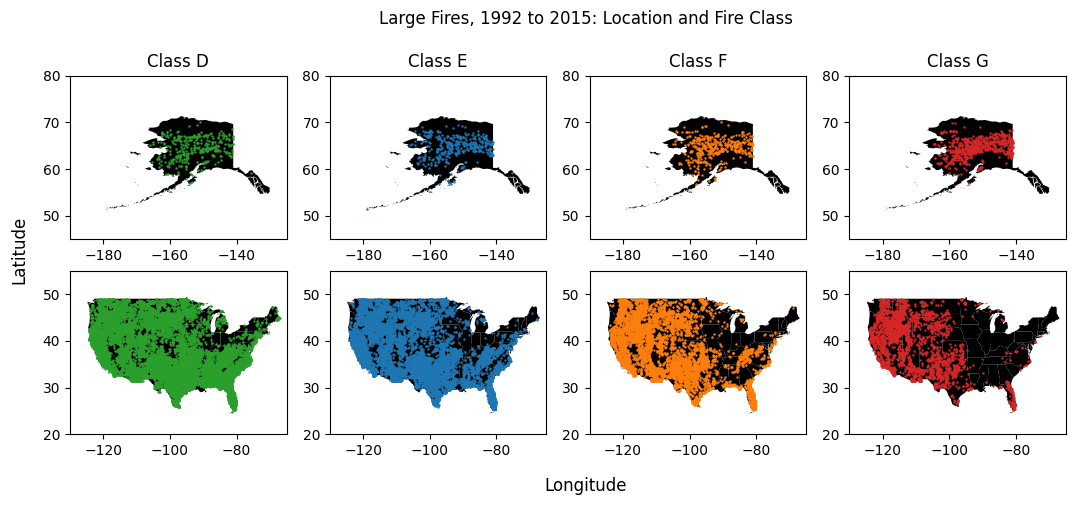

In [ ]:
#number of fires by type visualized on a US map
states = geopandas.read_file('/content/drive/My Drive/Courses Fall 2023/ORCA/Final Project/us_map/cb_2018_us_state_20m.shp')
type(states)
states = states.to_crs("EPSG:4326") #changes geopandas map to lat/long

#contiguous US maps
fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(12,5))
fig.subplots_adjust(left=0.07, wspace=0.2, bottom=0.1, hspace=0.001)
ax[0,0] = states.plot(ax=ax[0,0],color="black")
ax[0,0].scatter(fire_data_cleaned.loc[fire_data_cleaned.CLASS=="D",:].LONGITUDE, fire_data_cleaned.loc[fire_data_cleaned.CLASS=="D",:].LATITUDE,color="C2",s=.5)
ax[0,0].set_title("Class D")
ax[0,0].set_xlim([-190,-125])
ax[0,0].set_ylim([45,80])

ax[0,1] = states.plot(ax=ax[0,1],color="black")
ax[0,1].scatter(fire_data_cleaned.loc[fire_data_cleaned.CLASS=="E",:].LONGITUDE, fire_data_cleaned.loc[fire_data_cleaned.CLASS=="E",:].LATITUDE,color="C0",s=.5)
ax[0,1].set_title("Class E")
ax[0,1].set_xlim([-190,-125])
ax[0,1].set_ylim([45,80])

ax[0,2] = states.plot(ax=ax[0,2],color="black")
ax[0,2].scatter(fire_data_cleaned.loc[fire_data_cleaned.CLASS=="F",:].LONGITUDE, fire_data_cleaned.loc[fire_data_cleaned.CLASS=="F",:].LATITUDE,color="C1",s=.5)
ax[0,2].set_title("Class F")
ax[0,2].set_xlim([-190,-125])
ax[0,2].set_ylim([45,80])

ax[0,3] = states.plot(ax=ax[0,3],color="black")
ax[0,3].scatter(fire_data_cleaned.loc[fire_data_cleaned.CLASS=="G",:].LONGITUDE, fire_data_cleaned.loc[fire_data_cleaned.CLASS=="G",:].LATITUDE,color="C3",s=.5)
ax[0,3].set_title("Class G")
ax[0,3].set_xlim([-190,-125])
ax[0,3].set_ylim([45,80])

#alaska maps
ax[1,0] = states.plot(ax=ax[1,0],color="black")
ax[1,0].scatter(fire_data_cleaned.loc[fire_data_cleaned.CLASS=="D",:].LONGITUDE, fire_data_cleaned.loc[fire_data_cleaned.CLASS=="D",:].LATITUDE,color="C2",s=.5)
ax[1,0].set_xlim([-130,-65])
ax[1,0].set_ylim([20,55])

ax[1,1] = states.plot(ax=ax[1,1],color="black")
ax[1,1].scatter(fire_data_cleaned.loc[fire_data_cleaned.CLASS=="E",:].LONGITUDE, fire_data_cleaned.loc[fire_data_cleaned.CLASS=="E",:].LATITUDE,color="C0",s=.5)
ax[1,1].set_xlim([-130,-65])
ax[1,1].set_ylim([20,55])

ax[1,2] = states.plot(ax=ax[1,2],color="black")
ax[1,2].scatter(fire_data_cleaned.loc[fire_data_cleaned.CLASS=="F",:].LONGITUDE, fire_data_cleaned.loc[fire_data_cleaned.CLASS=="F",:].LATITUDE,color="C1",s=.5)
ax[1,2].set_xlim([-130,-65])
ax[1,2].set_ylim([20,55])

ax[1,3] = states.plot(ax=ax[1,3],color="black")
ax[1,3].scatter(fire_data_cleaned.loc[fire_data_cleaned.CLASS=="G",:].LONGITUDE, fire_data_cleaned.loc[fire_data_cleaned.CLASS=="G",:].LATITUDE,color="C3",s=.5)
ax[1,3].set_xlim([-130,-65])
ax[1,3].set_ylim([20,55])

fig.suptitle("Large Fires, 1992 to 2015: Location and Fire Class")
fig.supxlabel("Longitude")
fig.supylabel("Latitude")

plt.show()

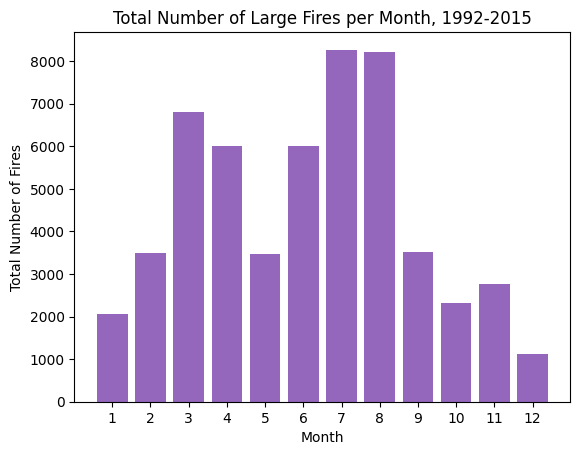

In [ ]:
#number of fires by month
month_breakdown = fire_data_cleaned.copy()
month_breakdown["MONTH"] = month_breakdown.DISC_DATE.dt.month
month_breakdown = month_breakdown.groupby(by="MONTH").count().reset_index()
month_breakdown = month_breakdown.loc[:,["MONTH","ID"]]
month_breakdown["MONTH"] = month_breakdown["MONTH"].astype("int")

plt.bar(month_breakdown.MONTH.astype("string"),month_breakdown.ID,color="C4")
plt.xlabel("Month")
plt.ylabel("Total Number of Fires")
plt.title("Total Number of Large Fires per Month, 1992-2015")
plt.show()

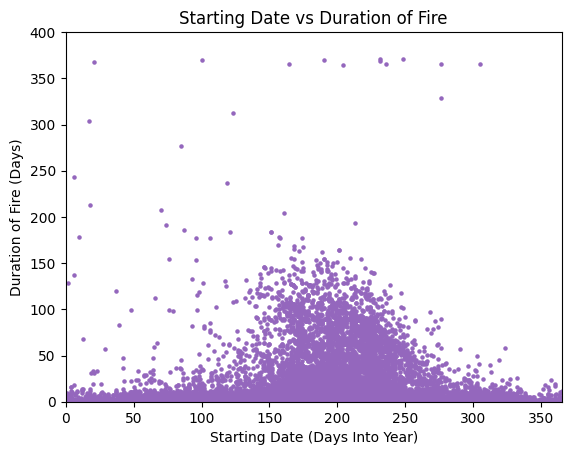

In [ ]:
duration_breakdown = fire_data_cleaned.copy()
duration_breakdown["YEAR"] = duration_breakdown.DISC_DATE.dt.year
duration_breakdown["BASE_DATE"] = "Jan 1, " + duration_breakdown["YEAR"].astype(str)
duration_breakdown["BASE_DATE"] = pd.to_datetime(duration_breakdown["BASE_DATE"])
correction = pd.to_timedelta("1 day")
duration_breakdown["DAYINTOYEAR"] = duration_breakdown.DISC_DATE - duration_breakdown.BASE_DATE + correction
plt.scatter(duration_breakdown.DAYINTOYEAR.dt.days.astype(float),duration_breakdown.DURATION.dt.days.astype(float),s=5,color="C4")
plt.xlim([0,365])
plt.ylim([0,400]) #cuts off five data points above 750 days
plt.xlabel("Starting Date (Days Into Year)")
plt.ylabel("Duration of Fire (Days)")
plt.title("Starting Date vs Duration of Fire")
plt.show()

In [ ]:
fire_data_cleaned["DAYINTOYEAR"] = duration_breakdown["DAYINTOYEAR"].dt.days.astype(int) #will be used for prediction later

In [ ]:
#average duration by classification
duration_numeric = fire_data_cleaned.copy()
duration_numeric.DURATION = duration_numeric.DURATION.dt.days
duration_numeric.groupby(by="CLASS").mean(numeric_only=True).loc[:,"DURATION"]

CLASS
D     4.117176
E     7.406832
F    14.321441
G    32.397392
Name: DURATION, dtype: float64

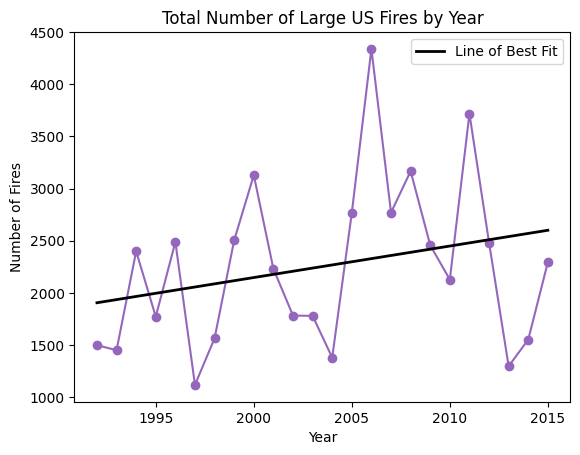

In [ ]:
#total number of fires per year over time
year_breakdown = fire_data_cleaned.loc[:,["ID","CLASS","DISC_DATE"]].copy()
year_breakdown["YEAR"] = year_breakdown.DISC_DATE.dt.year
year_breakdown = year_breakdown.groupby(by=["YEAR","CLASS"]).count()
year_breakdown = year_breakdown.loc[:,"ID"].unstack()
year_breakdown["TOTAL"] = year_breakdown.D + year_breakdown.E + year_breakdown.F + year_breakdown.G
year_breakdown = year_breakdown.reset_index()

plt.plot(year_breakdown.YEAR,year_breakdown.TOTAL, marker='o',label='',color="C4")

a, b = np.polyfit(year_breakdown.YEAR, year_breakdown.TOTAL, 1)
plt.plot(year_breakdown.YEAR, a*year_breakdown.YEAR+b,label="Line of Best Fit",color="black",linewidth=2.0)

plt.ylabel("Number of Fires")
plt.xlabel("Year")
plt.title("Total Number of Large US Fires by Year")
plt.legend()
plt.show()

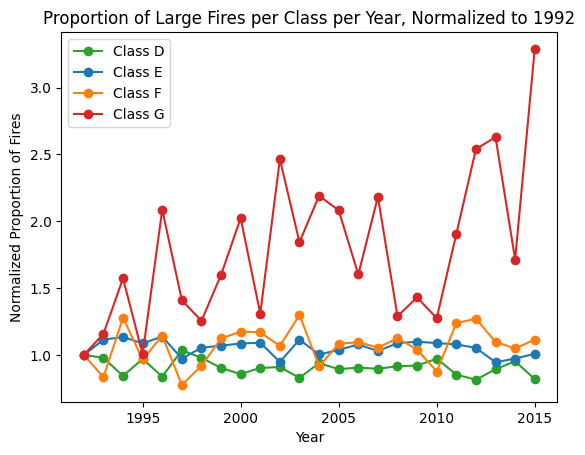

In [ ]:
#percent of wildfires of each class by year, normalized to 1992
dnorm = year_breakdown.D[0]/year_breakdown.TOTAL[0]*100
enorm = year_breakdown.E[0]/year_breakdown.TOTAL[0]*100
fnorm = year_breakdown.F[0]/year_breakdown.TOTAL[0]*100
gnorm = year_breakdown.G[0]/year_breakdown.TOTAL[0]*100

plt.plot(year_breakdown.YEAR,year_breakdown.D/year_breakdown.TOTAL/dnorm*100, marker='o',label='Class D',color="C2")
plt.plot(year_breakdown.YEAR,year_breakdown.E/year_breakdown.TOTAL/enorm*100, marker='o',label='Class E',color="C0")
plt.plot(year_breakdown.YEAR,year_breakdown.F/year_breakdown.TOTAL/fnorm*100, marker='o',label='Class F',color="C1")
plt.plot(year_breakdown.YEAR,year_breakdown.G/year_breakdown.TOTAL/gnorm*100, marker='o',label='Class G',color="C3")
plt.title("Proportion of Large Fires per Class per Year, Normalized to 1992")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Normalized Proportion of Fires")
plt.show()

# **PREDICTION**
# *Model 1*

In [ ]:
#predicting the severity (class) of a fire using the location (state, lat/long, or both), cause, day into year, and year
#sklearn decision tree does not handle categorical variables, so they must be converted into binary ones
tree_dataset = pd.get_dummies(fire_data_cleaned.drop(["ID","DURATION","CONT_DATE"],axis=1),columns=["STATE","CAUSE_DESCR"])
tree_dataset = tree_dataset.dropna() #drops 18 rows that cannot be natively modeled by sklearn
tree_dataset["DISC_DATE"] = tree_dataset.loc[:,"DISC_DATE"].dt.year.astype(int)
tree_dataset

,DISC_DATE,CLASS,LATITUDE,LONGITUDE,DAYINTOYEAR,STATE_AK,STATE_AL,STATE_AR,STATE_AZ,STATE_CA,...,CAUSE_DESCR_Debris Burning,CAUSE_DESCR_Equipment Use,CAUSE_DESCR_Fireworks,CAUSE_DESCR_Lightning,CAUSE_DESCR_Miscellaneous,CAUSE_DESCR_Missing/Undefined,CAUSE_DESCR_Powerline,CAUSE_DESCR_Railroad,CAUSE_DESCR_Smoking,CAUSE_DESCR_Structure
0,2004,G,38.523335,-120.211670,280,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,2004,G,38.779999,-120.260002,287,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,2005,D,36.001667,-81.589996,43,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,2005,D,43.899166,-102.954720,197,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,2005,D,43.892776,-102.948059,197,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54070,2009,D,40.463516,-124.386818,15,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
54071,2015,D,37.072712,-119.694153,172,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
54072,2008,F,40.956982,-121.321236,174,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
54073,2014,E,37.600388,-120.191170,157,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
train, valid = train_test_split(tree_dataset,test_size=0.2,random_state=7)

#model 1: using state instead of lat/long
model1 = DecisionTreeClassifier(max_depth=10)
model1.fit(train.drop(["LATITUDE","LONGITUDE","CLASS"], axis=1), train['CLASS'])
acc1 = accuracy_score(valid['CLASS'],model1.predict(valid.drop(["LATITUDE","LONGITUDE","CLASS"], axis=1)))

#model 2: using lat/long instead of state
model2 = DecisionTreeClassifier(max_depth=12)
predictors = ["LATITUDE","LONGITUDE","DAYINTOYEAR","CAUSE_DESCR_Debris Burning","CAUSE_DESCR_Arson","CAUSE_DESCR_Campfire","CAUSE_DESCR_Children","CAUSE_DESCR_Equipment Use","CAUSE_DESCR_Fireworks","CAUSE_DESCR_Lightning","CAUSE_DESCR_Miscellaneous","CAUSE_DESCR_Missing/Undefined","CAUSE_DESCR_Powerline","CAUSE_DESCR_Railroad","CAUSE_DESCR_Smoking","CAUSE_DESCR_Structure"]
outcome = "CLASS"
model2.fit(train[predictors], train[outcome])
acc2 = accuracy_score(valid[outcome],model2.predict(valid[predictors]))

#model 3: using both
model3 = DecisionTreeClassifier(max_depth=10)
model3.fit(train.drop(["CLASS"], axis=1), train['CLASS'])
acc3 = accuracy_score(valid['CLASS'],model3.predict(valid.drop(["CLASS"], axis=1)))

acc1, acc2, acc3

(0.5282478039759593, 0.5173370319001387, 0.5187239944521498)

In [ ]:
#example: lightning strike in Colorado, December, 30 2021 (Marshall fire)
modelstate = DecisionTreeClassifier(max_depth=10)
modelstate.fit(tree_dataset.drop(["LATITUDE","LONGITUDE","CLASS"], axis=1), tree_dataset['CLASS'])

test_point = pd.DataFrame(tree_dataset.iloc[0,:]).transpose()
test_point.DISC_DATE = 2021
test_point.DAYINTOYEAR = 364
test_point.CAUSE_DESCR_Powerline = 1
test_point["CAUSE_DESCR_Equipment Use"] = 0 #old cause
test_point.STATE_CA = 0 #old state
test_point.STATE_CO = 1

modelstate.predict(test_point.drop(["LATITUDE","LONGITUDE","CLASS"], axis=1))

array(['D'], dtype=object)

# *Model 2*

In [ ]:
#predicting number of each class of fire in a month in a state
#first grouping to determine the number of each class of fire in a state in a month
nummonth = fire_data_cleaned.copy()
nummonth = nummonth.drop(['ID',"CONT_DATE","LATITUDE","LONGITUDE","CAUSE_DESCR","DURATION","DAYINTOYEAR"], axis=1)
nummonth["MONTH"] = nummonth.DISC_DATE.dt.month_name()
nummonth["YEAR"] = nummonth.DISC_DATE.dt.year - 1992 #normalized to 1992
nummonth["COUNT"] = 1
nummonth = nummonth.drop("DISC_DATE",axis=1)
nummonth = nummonth.groupby(by=["CLASS","STATE","MONTH","YEAR"]).count()
nummonth = nummonth.reset_index()
nummonth.sort_values(by="COUNT",ascending=False)

,CLASS,STATE,MONTH,YEAR,COUNT
11126,G,AK,June,23,132
4403,D,TX,February,16,121
4421,D,TX,January,14,118
4423,D,TX,January,16,115
4365,D,TX,August,19,100
...,...,...,...,...,...
3958,D,SC,January,23,1
3960,D,SC,July,4,1
3961,D,SC,July,5,1
3964,D,SC,July,9,1


In [ ]:
#breaking the dataset up by class
classD = nummonth.loc[nummonth.CLASS == "D",:].copy()
classE = nummonth.loc[nummonth.CLASS == "E",:].copy()
classF = nummonth.loc[nummonth.CLASS == "F",:].copy()
classG = nummonth.loc[nummonth.CLASS == "G",:].copy()

#mean number of fires per state per month for comparison to MSE--direct mean is not used so that all months can be manually accounted for
classD.COUNT.sum()/(12*24*50), classE.COUNT.sum()/(12*24*50), classF.COUNT.sum()/(12*24*50), classG.COUNT.sum()/(12*24*50)

(1.9730555555555556,
 0.9794444444444445,
 0.5406944444444445,
 0.2620138888888889)

In [ ]:
#class D model
trainD, validD = train_test_split(classD,test_size=0.2,random_state=9,stratify=classD[["YEAR"]])
modelD = ols("COUNT~CLASS+STATE+MONTH+YEAR",trainD).fit()
modelD_predict = modelD.predict(validD)
mean_squared_error(validD.COUNT,modelD_predict), np.sqrt(mean_squared_error(validD.COUNT,modelD_predict))

(55.57229775514641, 7.45468294128908)

In [ ]:
conf_intD = pd.DataFrame(modelD.conf_int(0.05), copy=True)
conf_intD.columns = ["Low", "High"]
conf_intD.loc[conf_intD.Low*conf_intD.High >= 0, :]

,Low,High
Intercept,2.063380,6.148900
STATE[T.AL],0.087175,4.630064
STATE[T.CA],3.588381,7.999424
STATE[T.FL],2.410191,6.780932
STATE[T.ID],1.731928,6.430719
STATE[T.KY],4.976359,9.845890
STATE[T.MN],0.530366,5.541305
STATE[T.MS],1.291375,5.832644
STATE[T.OK],3.579987,8.088372
STATE[T.TX],10.150857,14.510714


In [ ]:
#class E model
trainE, validE = train_test_split(classE,test_size=0.2,random_state=9,stratify=classE[["YEAR"]])
modelE = ols("COUNT~CLASS+STATE+MONTH+YEAR",trainE).fit()
modelE_predict = modelE.predict(validE)
mean_squared_error(validE.COUNT,modelE_predict), np.sqrt(mean_squared_error(validE.COUNT,modelE_predict))

(27.949686992546518, 5.286746352204399)

In [ ]:
conf_intE = pd.DataFrame(modelE.conf_int(0.05), copy=True)
conf_intE.columns = ["Low", "High"]
conf_intE.loc[conf_intE.Low*conf_intE.High >= 0, :]

,Low,High
Intercept,2.299677,5.165246
STATE[T.CA],1.122244,4.136124
STATE[T.CO],-3.439182,-0.041560
STATE[T.GA],-4.033587,-0.126066
STATE[T.HI],-4.407634,-0.386346
STATE[T.ID],0.725774,3.964042
STATE[T.KY],1.615378,5.292254
STATE[T.LA],-3.791272,-0.294397
STATE[T.NC],-3.954215,-0.229573
STATE[T.NE],-3.965559,-0.285460


In [ ]:
#class F model
trainF, validF = train_test_split(classF,test_size=0.2,random_state=7,stratify=classF[["YEAR"]])
modelF = ols("COUNT~CLASS+STATE+MONTH+YEAR",trainF).fit()
modelF_predict = modelF.predict(validF)
mean_squared_error(validF.COUNT,modelF_predict), np.sqrt(mean_squared_error(validF.COUNT,modelF_predict))

(23.99984440744111, 4.898963605441574)

In [ ]:
conf_intF = pd.DataFrame(modelF.conf_int(0.05), copy=True)
conf_intF.columns = ["Low", "High"]
conf_intF.loc[conf_intF.Low*conf_intF.High >= 0, :]

,Low,High
Intercept,2.748326,5.279288
STATE[T.AL],-5.100505,-1.022548
STATE[T.AR],-5.290160,-1.433699
STATE[T.AZ],-2.874413,-0.313333
STATE[T.CO],-4.327739,-1.476127
STATE[T.FL],-3.431565,-0.856278
STATE[T.GA],-4.896188,-0.825131
STATE[T.HI],-5.165799,-1.747038
STATE[T.ID],0.670421,3.415574
STATE[T.KS],-3.827229,-0.599660


In [ ]:
#class G model
trainG, validG = train_test_split(classG,test_size=0.2,random_state=7,stratify=classG[["YEAR"]])
modelG = ols("COUNT~CLASS+STATE+MONTH+YEAR",trainG).fit()
modelG_predict = modelG.predict(validG)
mean_squared_error(validG.COUNT,modelG_predict), np.sqrt(mean_squared_error(validG.COUNT,modelG_predict))

(19.17442239781575, 4.3788608561834605)

In [ ]:
conf_intG = pd.DataFrame(modelG.conf_int(0.05), copy=True)
conf_intG.columns = ["Low", "High"]
conf_intG.loc[conf_intG.Low*conf_intG.High >= 0, :]

,Low,High
Intercept,5.958010,10.365592
STATE[T.AR],-16.721397,-0.178807
STATE[T.AZ],-9.763167,-5.418707
STATE[T.CA],-7.960705,-4.031005
STATE[T.CO],-11.030172,-6.084431
STATE[T.FL],-9.861975,-5.486830
STATE[T.GA],-13.129661,-3.837034
STATE[T.HI],-14.704654,-4.896543
STATE[T.ID],-6.693715,-2.288137
STATE[T.KS],-10.709184,-4.677417
